In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/henrikolaussen/Documents/STAT3007-timeseries_forecasting/data/eqnr_max_daily.csv')
data.head() 

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_close
0,2001-06-18 00:00:00-04:00,2.507966,2.514672,2.504613,2.504613,7189500,0.0,0.0,-0.973381
1,2001-06-19 00:00:00-04:00,2.531437,2.591789,2.531437,2.554907,1410700,0.0,0.0,-0.970356
2,2001-06-20 00:00:00-04:00,2.575024,2.578377,2.551554,2.561613,550400,0.0,0.0,-0.969953
3,2001-06-21 00:00:00-04:00,2.538143,2.548201,2.531437,2.538143,643600,0.0,0.0,-0.971364
4,2001-06-22 00:00:00-04:00,2.521378,2.531437,2.507967,2.518025,822600,0.0,0.0,-0.972574


In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device} for this proj!")

Using device: cpu for this proj!


In [3]:
#min/max scaling 
scaler = MinMaxScaler(feature_range=(-1, 1))
data['Scaled_close'] = scaler.fit_transform(data[['Close']])
data_raw = data[['Date','Scaled_close']]
data_raw.head()

,Date,Scaled_close
0,2001-06-18 00:00:00-04:00,-0.973381
1,2001-06-19 00:00:00-04:00,-0.970356
2,2001-06-20 00:00:00-04:00,-0.969953
3,2001-06-21 00:00:00-04:00,-0.971364
4,2001-06-22 00:00:00-04:00,-0.972574


In [4]:
train_data = data_raw[0:int(len(data_raw)*0.80)]
test_data = data_raw[int(len(data_raw)*0.80):]

print('train data shape: ', train_data.shape)
print('test data shape: ', test_data.shape)

train data shape:  (4596, 2)
test data shape:  (1150, 2)


Split into sequences with a given number of time steps as look back.

In [5]:
def get_sequences(df: pd.DataFrame, sequence_length: int):
    data = df.drop(columns=['Date']).to_numpy()
    sequences = []
    for index in range(len(data) - sequence_length):
        sequence = data[index : index + sequence_length+1]
        sequences.append(sequence)
    
    return torch.tensor(sequences).float()

In [6]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self,x):
        self.x = x
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,i):
        return self.x[i]

Fixing the data

### Implement RNN

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.rnn_layer = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.dense_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, unbatched = False):
        batch_size = x.shape[0]

        if unbatched:
            h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_()
        else:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()

        h0 = h0.to(self.device)
        out = self.dense_layer(self.rnn_layer(x, h0)[0][:,-1,:])
        return out

Training and testing:

In [8]:
from tqdm import tqdm

def train(model, optimizer, dataloader, num_epochs, loss_func, prediction_horizon: int, gradient_clipping: bool):
   
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_batches = len(dataloader)
        for i, batch in enumerate(
            tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)
        ):
            optimizer.zero_grad()

            x = batch[:, :-prediction_horizon].to(
                device
            )  # All but the last n elements of each sequence
            targets = batch[:, -prediction_horizon:].to(
                device
            )  # Last n elements is targets
            targets = targets.squeeze()  # [batch_size, 1, 1] -> [batch_size]

            outputs = model(x)  # Forward pass
            outputs = outputs.squeeze()  # [batch_size, 1] -> [batch_size]

            loss = loss_func(outputs, targets)

            loss.backward()

            # Gradient clipping
            if gradient_clipping == True: 
                torch.nn.utils.clip_grad_norm_(model.parameters(), 10) #max_grad_norm = 5. 

            optimizer.step()

            running_loss += loss.item()

        '''
        # Print gradient values
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient norm: {param.grad.norm().item()}")
        '''
        avg_loss = running_loss / total_batches
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.10f}")


def test(net, forecast_steps, test_loader):
    device = next(net.parameters()).device
    loss_function = nn.MSELoss(reduction = 'mean')
    net.eval()
    with torch.no_grad():
        tot_test_loss = 0.0
        n_batches = len(test_loader)
        for batch in test_loader:
            batch = batch.to(device)

            test_pred = net(batch[:,:-forecast_steps])

            test_loss = loss_function(test_pred, batch[:,-forecast_steps:].squeeze(2))

            tot_test_loss += test_loss.item()
        return tot_test_loss/n_batches

Forecasting of a single stock:

In [9]:
x_forecast = torch.tensor(test_data['Scaled_close'].values, dtype = torch.float32) #test data to be used for forecasting

def forecast_rolling(net, x_forecast, m, forecast_steps, look_back, plot = True): #'rolling' forecast 
    ''' 
    x_forecast: one dimentional tensor of unseen test data 
    m: first test point in historical data (of test data/unseen data)
    '''
    #forecast x number of days into the future. Use previous predictions in the look-back sequence historical data
    historical_data = x_forecast[m:m+look_back].unsqueeze(0).unsqueeze(2)
    hist_data_plot = historical_data.squeeze(2).squeeze(0).detach().numpy()
    forecasted_values = []
    with torch.no_grad():
        for i in range(forecast_steps):
            pred = net(historical_data)
            forecasted_values.append(float(pred.detach().numpy()))
            historical_data = historical_data.roll(shifts=-1)
            historical_data[-1][-1] = pred
            
    if plot == True: 
        days = np.arange(1,look_back + forecast_steps+1,1)
        plt.plot(days[-forecast_steps:], np.array(x_forecast[m+look_back:m+look_back+forecast_steps]),'o-', label = 'Test data')
        plt.plot(days[-forecast_steps:], forecasted_values,'.-', label = 'Forecasted values')
        plt.plot(days[:-forecast_steps],hist_data_plot, '.-', label = 'Historical data')
        #plt.ylim(-1,1)
        plt.title(f'Forecast of {forecast_steps} days')
        plt.xlabel('days')
        plt.ylabel('scaled close')
        plt.legend()
        plt.grid()
        plt.show()

In [10]:
def forecast(net, ts_viz, sequence_length, forecast_steps, model_type: str, plot=True): #multistep forecast 
    device = next(net.parameters()).device
    historical_data = ts_viz[300:300+sequence_length-forecast_steps].unsqueeze(0).unsqueeze(2)
    hist_data_plot = historical_data.squeeze(2).squeeze(0).detach().numpy()

    with torch.no_grad():
        historical_data = historical_data.to(device)
        pred = net(historical_data)

    if plot:
        days = np.arange(1, sequence_length + 1)

        vals = ts_viz[300+sequence_length-forecast_steps:300+sequence_length].cpu().numpy()
        pred_cpu = pred.cpu().squeeze(0).numpy()  # Move prediction to CPU
   
        plt.plot(days[:-forecast_steps], hist_data_plot, 'o-', label='Test data')
        plt.plot(days[-forecast_steps:], pred_cpu, 'o-', label='Forecasted values')
        plt.plot(days[-forecast_steps:], vals, '.-', alpha=0.3, label='Actual values', color='tab:blue')
        plt.title(f'Forecast of {len(pred[0])} days for {model_type}')
        plt.xlabel('Days')
        plt.legend()
        plt.grid()
        #plt.savefig(f'{model_type} for Equinor data')
        plt.show()

In [17]:
forecast_steps = 5
sequence_length = 50 + forecast_steps

train_sequence = get_sequences(train_data, sequence_length)
test_sequence = get_sequences(test_data, sequence_length)

train_dataset = TimeSeriesDataset(train_sequence)
test_dataset = TimeSeriesDataset(test_sequence)

batch_size = 24

#train loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = 1
hidden_size = 512
num_layers = 1
output_size = forecast_steps

loss_function = nn.MSELoss(reduction = 'mean')
rnn = RNN(input_size, hidden_size, num_layers, output_size, device)
optimizer = optim.SGD(rnn.parameters(), lr=0.01)
train(rnn, optimizer, train_loader, num_epochs=10, loss_func=loss_function, prediction_horizon=forecast_steps, gradient_clipping=False)

Epoch 1/10: 100%|█████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


Epoch 1/10, Average Loss: 0.0821197068


Epoch 2/10: 100%|█████████████████████████████████████████████████| 190/190 [00:08<00:00, 23.72it/s]


Epoch 2/10, Average Loss: 0.0275930058


Epoch 3/10: 100%|█████████████████████████████████████████████████| 190/190 [00:07<00:00, 24.76it/s]


Epoch 3/10, Average Loss: 0.0026712292


Epoch 4/10: 100%|█████████████████████████████████████████████████| 190/190 [00:06<00:00, 28.65it/s]


Epoch 4/10, Average Loss: 0.0014713102


Epoch 5/10: 100%|█████████████████████████████████████████████████| 190/190 [00:05<00:00, 33.28it/s]


Epoch 5/10, Average Loss: 0.0013712699


Epoch 6/10: 100%|█████████████████████████████████████████████████| 190/190 [00:05<00:00, 33.94it/s]


Epoch 6/10, Average Loss: 0.0013138578


Epoch 7/10: 100%|█████████████████████████████████████████████████| 190/190 [00:05<00:00, 32.36it/s]


Epoch 7/10, Average Loss: 0.0012498456


Epoch 8/10: 100%|█████████████████████████████████████████████████| 190/190 [00:05<00:00, 33.16it/s]


Epoch 8/10, Average Loss: 0.0012077343


Epoch 9/10: 100%|█████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.17it/s]


Epoch 9/10, Average Loss: 0.0011722934


Epoch 10/10: 100%|████████████████████████████████████████████████| 190/190 [00:07<00:00, 26.03it/s]

Epoch 10/10, Average Loss: 0.0011408177


In [18]:
test(rnn, forecast_steps, test_loader)

0.004528689255138212

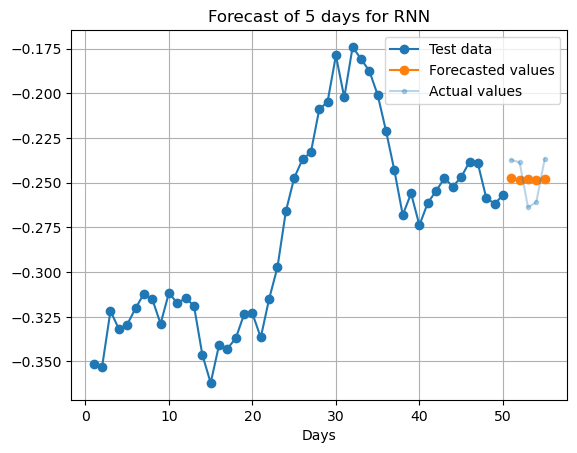

In [19]:
forecast(rnn, torch.tensor(test_data['Scaled_close'].to_numpy(), dtype=torch.float32), sequence_length, forecast_steps, 'RNN')